In [40]:
import pandas as pd

train_data = pd.read_csv('/home-asustor/teramoto/SIGNATE/EX/Titanic/data/train.tsv', sep='\t')
test_data = pd.read_csv('/home-asustor/teramoto/SIGNATE/EX/Titanic/data/test.tsv', sep='\t')

In [41]:
print(train_data.head())
print(test_data.head())

   id  survived  pclass     sex   age  sibsp  parch     fare embarked
0   3         1       1  female  35.0      1      0  53.1000        S
1   4         0       3    male  35.0      0      0   8.0500        S
2   7         0       3    male   2.0      3      1  21.0750        S
3   9         1       2  female  14.0      1      0  30.0708        C
4  11         1       1  female  58.0      0      0  26.5500        S
   id  pclass     sex   age  sibsp  parch     fare embarked
0   0       3    male  22.0      1      0   7.2500        S
1   1       1  female  38.0      1      0  71.2833        C
2   2       3  female  26.0      0      0   7.9250        S
3   5       3    male   NaN      0      0   8.4583        Q
4   6       1    male  54.0      0      0  51.8625        S


In [42]:
# 家族の人数の特徴量を追加
train_data['family_size'] = train_data['sibsp'] + train_data['parch'] + 1
test_data['family_size'] = test_data['sibsp'] + test_data['parch'] + 1

# 人数ごとの運賃
train_data['fare_per_person'] = train_data['fare'] / train_data['family_size']
test_data['fare_per_person'] = test_data['fare'] / test_data['family_size']

# 年齢の欠損値を中央値で補完
train_data['age'].fillna(train_data['age'].median(), inplace=True)
test_data['age'].fillna(test_data['age'].median(), inplace=True)


X = train_data.drop('survived', axis=1)
y = train_data['survived']

In [43]:
X['sex'] = X['sex'].replace({'male': 1, 'female': 0})
X = pd.get_dummies(X, columns=['embarked'], drop_first=True)
# X['embarked'] = X['embarked'].replace({'S': 0, 'C': 1, 'Q': 2})
X = X.astype(int)

In [44]:
print(X.head())
print('----------------')
print(y.head())

   id  pclass  sex  age  sibsp  parch  fare  family_size  fare_per_person  \
0   3       1    0   35      1      0    53            2               26   
1   4       3    1   35      0      0     8            1                8   
2   7       3    1    2      3      1    21            5                4   
3   9       2    0   14      1      0    30            2               15   
4  11       1    0   58      0      0    26            1               26   

   embarked_Q  embarked_S  
0           0           1  
1           0           1  
2           0           1  
3           0           0  
4           0           1  
----------------
0    1
1    0
2    0
3    1
4    1
Name: survived, dtype: int64


In [45]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

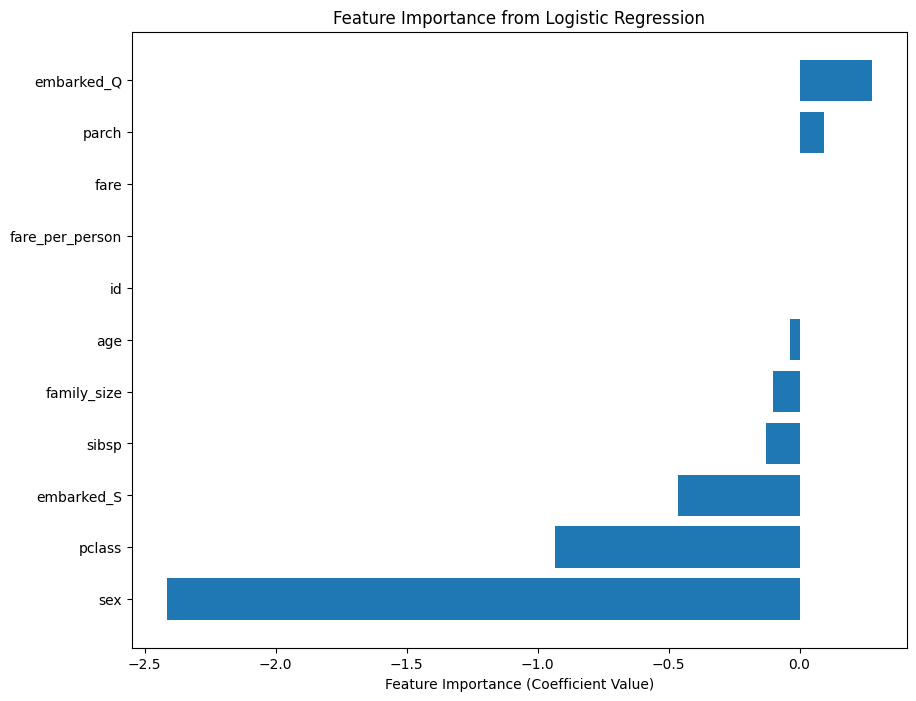

In [47]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

# 各特徴量の係数（重要度）を取得
feature_importance = model.coef_[0]

# 特徴量名の取得
features = X.columns

# 特徴量の影響度をソート
sorted_idx = np.argsort(feature_importance)

# 重要度のプロット
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel('Feature Importance (Coefficient Value)')
plt.title('Feature Importance from Logistic Regression')
plt.show()

In [48]:
y_pred = model.predict(X_valid)
roc_auc = roc_auc_score(y_valid, y_pred)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.864448051948052


In [49]:
# 各クラスに対する予測確率の取得 (クラス1の確率のみ取得)
y_pred_proba = model.predict_proba(X_valid)[:, 1]

# ROC AUCスコア（予測確率を使った評価）
roc_auc_proba = roc_auc_score(y_valid, y_pred_proba)

print("ROC AUC Score (using probabilities):", roc_auc_proba)


ROC AUC Score (using probabilities): 0.8836580086580087


In [50]:

test_data['sex'] = test_data['sex'].replace({'male': 1, 'female': 0})
test_data = pd.get_dummies(test_data, columns=['embarked'], drop_first=True)
# X['embarked'] = X['embarked'].replace({'S': 0, 'C': 1, 'Q': 2})
X = X.astype(int)
test_data = test_data[X.columns]

In [51]:
test_predictions = model.predict(test_data)
output = pd.DataFrame({'id': test_data['id'], 'prediction': test_predictions})
output.to_csv('/home-asustor/teramoto/SIGNATE/EX/Titanic/data/test_predictions.tsv', index=False, header=False, sep="	")
print("予測結果を '/home-asustor/teramoto/SIGNATE/EX/Titanic/data/test_predictions.tsv' に保存しました。")

予測結果を '/home-asustor/teramoto/SIGNATE/EX/Titanic/data/test_predictions.tsv' に保存しました。


In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# 学習データとテストデータの分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# ランダムフォレストモデルの定義
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 学習
rf_model.fit(X_train, y_train)

# 検証データに対する予測
y_pred = rf_model.predict(X_valid)
roc_auc = roc_auc_score(y_valid, y_pred)

print("Random Forest ROC AUC Score:", roc_auc)


Random Forest ROC AUC Score: 0.8162878787878788


In [53]:
from sklearn.ensemble import GradientBoostingClassifier

# 勾配ブースティングモデルの定義
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# 学習
gb_model.fit(X_train, y_train)

# 検証データに対する予測
y_pred = gb_model.predict(X_valid)
roc_auc = roc_auc_score(y_valid, y_pred)

print("Gradient Boosting ROC AUC Score:", roc_auc)


Gradient Boosting ROC AUC Score: 0.8162878787878788


In [54]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# スタッキングモデルの定義
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# 学習
stacking_model.fit(X_train, y_train)

# 検証データに対する予測
y_pred = stacking_model.predict(X_valid)
roc_auc = roc_auc_score(y_valid, y_pred)

print("Stacking Classifier ROC AUC Score:", roc_auc)


Stacking Classifier ROC AUC Score: 0.8100649350649352


In [57]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# ロジスティック回帰、XGBoost、ランダムフォレストのモデルを構築
lr_model = LogisticRegression(max_iter=1000)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
rf_model = RandomForestClassifier(n_estimators=100)

# アンサンブル学習 (ソフトボーティング)
ensemble_model = VotingClassifier(estimators=[
    ('lr', lr_model),
    ('xgb', xgb_model),
    ('rf', rf_model)
], voting='soft')

# アンサンブルモデルの訓練
ensemble_model.fit(X_train, y_train)

# 検証データでの予測確率
y_pred_prob = ensemble_model.predict_proba(X_valid)[:, 1]

# AUCスコアの計算
auc_score = roc_auc_score(y_valid, y_pred_prob)
print(f'AUC: {auc_score}')

# 最適な閾値の算出
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_prob)
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]

# テストデータで予測
test_predictions = model.predict(test_data)
output = pd.DataFrame({'id': test_data['id'], 'prediction': test_predictions})
output.to_csv('/home-asustor/teramoto/SIGNATE/EX/Titanic/data/1test_predictions.tsv', index=False, header=False, sep="	")
print("予測結果を '/home-asustor/teramoto/SIGNATE/EX/Titanic/data/1test_predictions.tsv' に保存しました。")


AUC: 0.9042207792207793
予測結果を '/home-asustor/teramoto/SIGNATE/EX/Titanic/data/1test_predictions.tsv' に保存しました。


/home-asustor/teramoto/.conda/envs/detectron2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home-asustor/teramoto/.conda/envs/detectron2/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:37:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
